Hyperparameters

In [1]:
import torch

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:1")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.00001
BATCH_SIZE = 8
NUM_EPOCHS = 150
IMAGE_SIZE = 224
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
NUM_HEADS = 8
TRANSFORMER_LAYERS = 10

PROJECTION_DIM = 128
MLP_HEAD_UNITS = [512]


Using device: cuda:1


Reading and Combining training , test and validation dataset

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

image_size = 224

def find_label_from_folder(folder_name, labels):
    # Return the label whose prefix matches the folder_name
    for label in labels:
        if folder_name.startswith(label):
            return label
    raise ValueError(f"Cannot find label for folder {folder_name}")

def load_images(data_path, split_names=["train", "valid", "test"], labels=None, image_size=224):
    X = []
    y = []
    if labels is None:
        raise ValueError("You must provide the list of labels explicitly in this case.")
    for split_name in split_names:
        split_path = os.path.join(data_path, split_name)
        if not os.path.exists(split_path):
            return
        for folder_name in os.listdir(split_path):
            folder_path = os.path.join(split_path, folder_name)
            # Only process directories
            if not os.path.isdir(folder_path):
                continue
            try:
                label = find_label_from_folder(folder_name, labels)
            except ValueError as e:
                print(e)
                continue
            for img_name in tqdm(os.listdir(folder_path), desc=f"{split_name}/{folder_name}"):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue
                img = cv2.resize(img, (image_size, image_size))
                X.append(img)
                y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

data_path = ""
labels = ["adenocarcinoma", "large.cell.carcinoma", "normal", "squamous.cell.carcinoma"]

X, y = load_images(data_path, labels=labels, image_size=image_size)

train/normal: 100%|██████████| 148/148 [00:00<00:00, 345.50it/s]
train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 100%|██████████| 155/155 [00:00<00:00, 787.87it/s]
train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 100%|██████████| 115/115 [00:00<00:00, 812.85it/s]
valid/normal: 100%|██████████| 13/13 [00:00<00:00, 227.34it/s]
valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 100%|██████████| 15/15 [00:00<00:00, 849.18it/s]
valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 100%|██████████| 21/21 [00:00<00:00, 931.36it/s]
test/squamous.cell.carcinoma: 100%|██████████| 90/90 [00:00<00:00, 643.57it/s]


Splitting dataset into training and test data

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Data Augmentation and Preprocessing

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision

# Define constants
IMAGE_SIZE = 224
BATCH_SIZE = 32

label2idx = {
    "normal": 0,
    "adenocarcinoma": 1,
    "large.cell.carcinoma": 2,
    "squamous.cell.carcinoma": 3
}

idx2label = {
    0: "normal",
    1: "adenocarcinoma",
    2: "large.cell.carcinoma",
    3: "squamous.cell.carcinoma"
}

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

class AugmentedDataset(Dataset):
    def __init__(self, X, y, transform=None, augment_copies=0):
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Normalize and permute input images
        X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
        encoded_labels = [label2idx[l] if isinstance(l, str) else l for l in y]

        for img, label in zip(X, encoded_labels):
            self.images.append(img)
            self.labels.append(label)

            for _ in range(augment_copies):
                if self.transform:
                    aug_img = self.transform(img)
                    self.images.append(aug_img)
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]



train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.RandomRotation(degrees=7),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.Normalize(mean, std),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.Normalize(mean, std),
])


train_dataset = AugmentedDataset(X_train, y_train, transform=train_transforms)

test_dataset = AugmentedDataset(X_test, y_test, transform=test_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# Cleanup
# del train_dataset, valid_dataset, test_dataset

Visualizing different types of cancer images

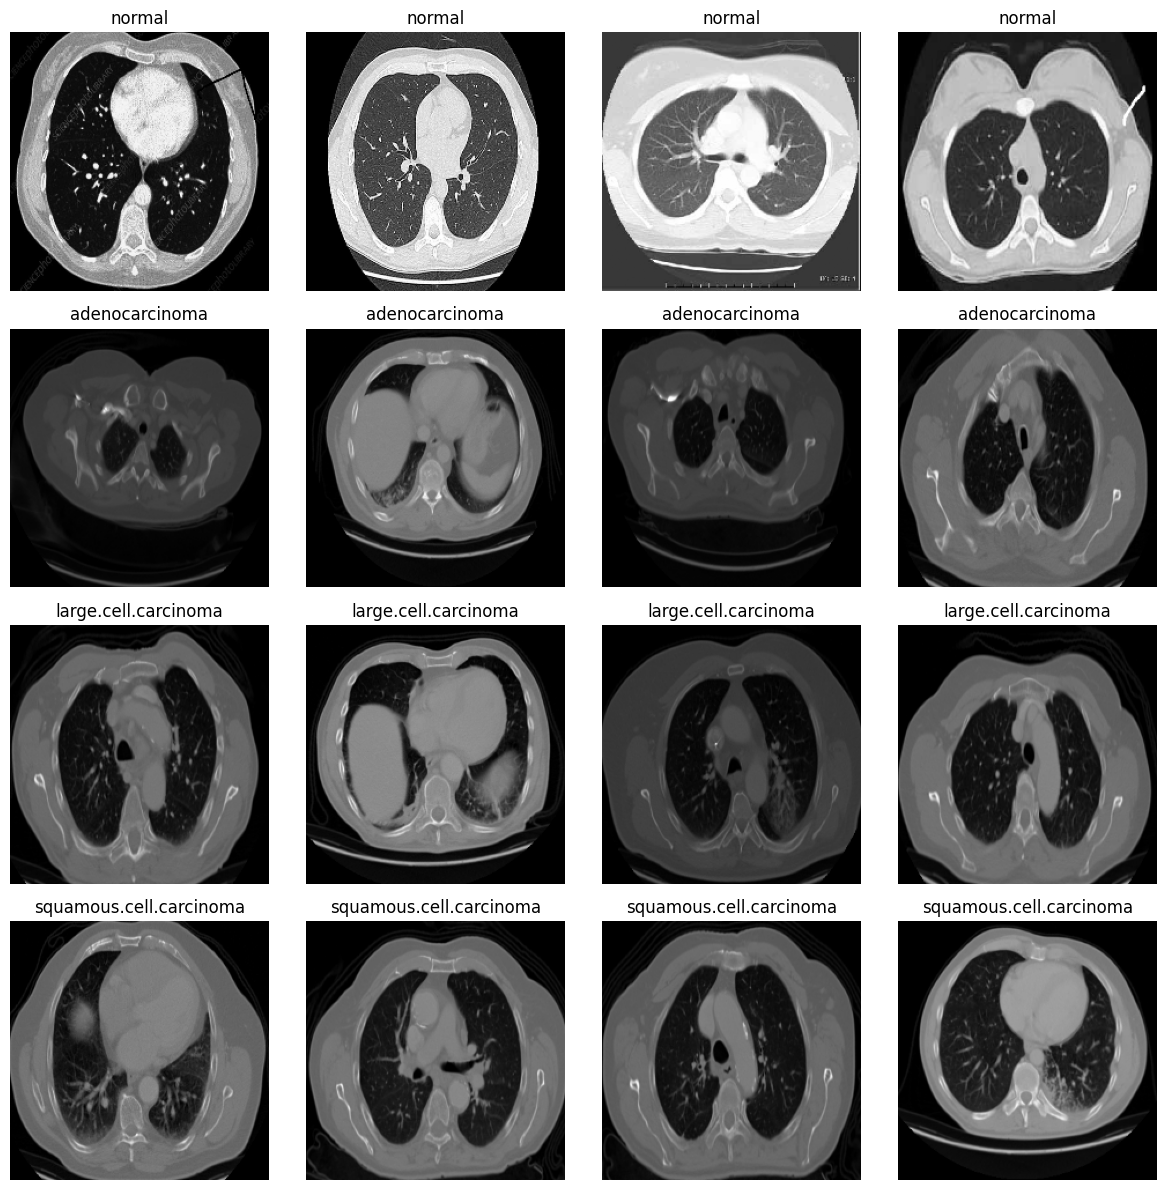

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(labels), 4, figsize=(12, len(labels) * 3))
labels = np.arange(4)
if len(labels) == 1:
    axes = np.expand_dims(axes, axis=0)

for i, label in enumerate(labels):
    indices = np.where(test_dataset.labels == label)[0]
    num_to_sample = len(indices)
    random_indices = np.random.choice(indices, size=num_to_sample, replace=False)
    for j in range(4):  # Always loop over 4 columns
        ax = axes[i, j]
        if j < num_to_sample:
            img = test_dataset.images[random_indices[j]]
            if isinstance(img, torch.Tensor):
                img = img.numpy()
                if img.ndim == 3 and img.shape[0] in [1, 3]:  # Likely CHW
                    img = np.transpose(img, (1, 2, 0))  # Convert to HWC
            
            elif isinstance(img, Image.Image):
                img = np.array(img)
            
            if isinstance(img, np.ndarray):
                if img.ndim == 3 and img.shape[2] == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img)
            else:
                print(f"Unexpected type: {type(img)}")
            ax.imshow(img)
            ax.set_title(idx2label[label])
        else:
            ax.axis("off")  # Hide unused subplots if less than 4 images available
        ax.axis("off")

plt.tight_layout()
plt.show()


Vision Transformer Model

In [6]:
from typing import Type

import torch
from torch import nn

class CreatePatchesLayer(torch.nn.Module):
    """Custom PyTorch Layer to Extract Patches from Images."""

    def __init__(
        self,
        patch_size: int,
        strides: int,
    ) -> None:
        """Init Variables."""
        super().__init__()
        self.unfold_layer = torch.nn.Unfold(
            kernel_size=patch_size, stride=strides
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """Forward Pass to Create Patches."""
        patched_images = self.unfold_layer(images)
        return patched_images.permute((0, 2, 1))


class PatchEmbeddingLayer(nn.Module):
    """Patch + Positional Embedding layer for Vision Transformers (ViT-style)."""

    def __init__(
        self,
        num_patches: int,
        patch_size: int,
        embed_dim: int,
        device: torch.device,
    ) -> None:
        
        super().__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.device = device

        self.projection_layer = nn.Linear(patch_size * patch_size * 3, embed_dim)

        self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim, device=device))

        self.position_embeddings = nn.Embedding(num_patches + 1, embed_dim)

    def forward(self, patches: torch.Tensor) -> torch.Tensor:
        
        B = patches.size(0)

        patch_embeddings = self.projection_layer(patches)

        cls_tokens = self.class_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, patch_embeddings), dim=1)

        position_ids = torch.arange(self.num_patches + 1, device=self.device).unsqueeze(0)
        x = x + self.position_embeddings(position_ids)

        return x


def create_mlp_block(
    input_features: int,
    output_features: list[int],
    activation_function: Type[torch.nn.Module],
    dropout_rate: float,
) -> torch.nn.Module:
    """Create a Feed Forward Network for the Transformer Layer."""
    layers = []
    in_features = input_features

    for out_features in output_features:
        layers.append(torch.nn.Linear(in_features, out_features))
        layers.append(activation_function())
        layers.append(torch.nn.Dropout(dropout_rate))
        in_features = out_features

    return torch.nn.Sequential(*layers)


class TransformerBlock(torch.nn.Module):
    """Transformer Block Layer with Residual Connections."""

    def __init__(
        self,
        num_heads: int,
        key_dim: int,
        embed_dim: int,
        ff_dim: int,
        dropout_rate: float = 0.2,
    ) -> None:
        super().__init__()

        self.norm1 = torch.nn.LayerNorm(embed_dim, eps=1e-6)
        self.attn = torch.nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            kdim=key_dim,
            vdim=key_dim,
            batch_first=True,
        )
        self.dropout1 = torch.nn.Dropout(dropout_rate)

        self.norm2 = torch.nn.LayerNorm(embed_dim, eps=1e-6)
        self.ffn = create_mlp_block(
            input_features=embed_dim,
            output_features=[ff_dim, embed_dim],
            activation_function=torch.nn.GELU,
            dropout_rate=dropout_rate,
        )
        self.dropout2 = torch.nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_norm1 = self.norm1(x)
        attn_output, _ = self.attn(x_norm1, x_norm1, x_norm1)
        x = x + self.dropout1(attn_output)

        x_norm2 = self.norm2(x)
        ffn_output = self.ffn(x_norm2)
        x = x + self.dropout2(ffn_output)
        return x

class ViTClassifierModel(torch.nn.Module):
  """ViT Model for Image Classification."""

  def __init__(
    self,
    num_transformer_layers: int,
    embed_dim: int,
    feed_forward_dim: int,
    num_heads: int,
    patch_size: int,
    num_patches: int,
    mlp_head_units: list[int],
    num_classes: int,
    batch_size: int,
    device: torch.device,
  ) -> None:

    super().__init__()
    self.create_patch_layer = CreatePatchesLayer(patch_size, patch_size)
    self.patch_embedding_layer = PatchEmbeddingLayer(
      num_patches, patch_size, embed_dim, device
    )
    self.transformer_layers = torch.nn.ModuleList()
    for _ in range(num_transformer_layers):
      self.transformer_layers.append(
        TransformerBlock(
          num_heads, embed_dim, embed_dim, feed_forward_dim
        )
      )

    self.mlp_block = create_mlp_block(
      input_features=embed_dim,
      output_features=mlp_head_units,
      activation_function=torch.nn.GELU,
      dropout_rate=0.2,
      )

    self.out_proj = torch.nn.Linear(mlp_head_units[-1], num_classes)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.create_patch_layer(x)
    x = self.patch_embedding_layer(x)
    for transformer_layer in self.transformer_layers:
      x = transformer_layer(x)
    x = x[:, 0]
    x = self.mlp_block(x)
    x = self.out_proj(x)
    return x

Training the model using early stopping method (training data split into training and validation in 90:10 ratio)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split

class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


def train(model, train_loader, val_loader, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = torch.nn.CrossEntropyLoss()
    model.to(device)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
    early_stopper = EarlyStopping(patience=15, verbose=True)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

        early_stopper(avg_val_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break


# Test function remains unchanged
def test_and_report(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X, y in tqdm(test_loader):
            X = X.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=list(label2idx.keys())))

total_len = len(train_dataset)
train_len = int(0.90 * total_len)
val_len = total_len - train_len
train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = ViTClassifierModel(
    num_transformer_layers=TRANSFORMER_LAYERS,
    embed_dim=PROJECTION_DIM,
    feed_forward_dim=PROJECTION_DIM * 2,
    num_heads=NUM_HEADS,
    patch_size=PATCH_SIZE,
    num_patches=NUM_PATCHES,
    mlp_head_units=MLP_HEAD_UNITS,
    num_classes=4,
    batch_size=BATCH_SIZE,
    device=device,
)

train(model, train_loader, val_loader, epochs=NUM_EPOCHS)

print("Scores on test data:")
test_and_report(model, test_loader)

100%|██████████| 23/23 [00:09<00:00,  2.37it/s]


Epoch 1/150 - Train Loss: 1.3347 - Val Loss: 1.1633


100%|██████████| 23/23 [00:09<00:00,  2.37it/s]


Epoch 2/150 - Train Loss: 1.1974 - Val Loss: 1.2638
EarlyStopping counter: 1 out of 15


100%|██████████| 23/23 [00:09<00:00,  2.32it/s]


Epoch 3/150 - Train Loss: 1.0537 - Val Loss: 0.9575


100%|██████████| 23/23 [00:10<00:00,  2.26it/s]


Epoch 4/150 - Train Loss: 1.0442 - Val Loss: 1.1350
EarlyStopping counter: 1 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.23it/s]


Epoch 5/150 - Train Loss: 0.9411 - Val Loss: 0.9509


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 6/150 - Train Loss: 0.9294 - Val Loss: 0.8717


100%|██████████| 23/23 [00:10<00:00,  2.17it/s]


Epoch 7/150 - Train Loss: 0.8577 - Val Loss: 0.8341


100%|██████████| 23/23 [00:10<00:00,  2.15it/s]


Epoch 8/150 - Train Loss: 0.8698 - Val Loss: 0.8890
EarlyStopping counter: 1 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.14it/s]


Epoch 9/150 - Train Loss: 0.7899 - Val Loss: 0.9560
EarlyStopping counter: 2 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.13it/s]


Epoch 10/150 - Train Loss: 0.7616 - Val Loss: 0.8815
EarlyStopping counter: 3 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Epoch 11/150 - Train Loss: 0.7179 - Val Loss: 1.1405
EarlyStopping counter: 4 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Epoch 12/150 - Train Loss: 0.6352 - Val Loss: 0.8110


100%|██████████| 23/23 [00:10<00:00,  2.14it/s]


Epoch 13/150 - Train Loss: 0.5550 - Val Loss: 0.7026


100%|██████████| 23/23 [00:10<00:00,  2.16it/s]


Epoch 14/150 - Train Loss: 0.5617 - Val Loss: 0.7126
EarlyStopping counter: 1 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.17it/s]


Epoch 15/150 - Train Loss: 0.5352 - Val Loss: 0.9303
EarlyStopping counter: 2 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 16/150 - Train Loss: 0.4666 - Val Loss: 0.8175
EarlyStopping counter: 3 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 17/150 - Train Loss: 0.4651 - Val Loss: 1.0043
EarlyStopping counter: 4 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 18/150 - Train Loss: 0.4093 - Val Loss: 0.8907
EarlyStopping counter: 5 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 19/150 - Train Loss: 0.4952 - Val Loss: 0.7115
EarlyStopping counter: 6 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch 20/150 - Train Loss: 0.5188 - Val Loss: 0.7592
EarlyStopping counter: 7 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch 21/150 - Train Loss: 0.4146 - Val Loss: 0.8285
EarlyStopping counter: 8 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch 22/150 - Train Loss: 0.3698 - Val Loss: 0.8549
EarlyStopping counter: 9 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch 23/150 - Train Loss: 0.2851 - Val Loss: 0.7510
EarlyStopping counter: 10 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch 24/150 - Train Loss: 0.3140 - Val Loss: 0.7782
EarlyStopping counter: 11 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch 25/150 - Train Loss: 0.2468 - Val Loss: 1.0439
EarlyStopping counter: 12 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch 26/150 - Train Loss: 0.3551 - Val Loss: 1.1489
EarlyStopping counter: 13 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 27/150 - Train Loss: 0.2572 - Val Loss: 0.7584
EarlyStopping counter: 14 out of 15


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 28/150 - Train Loss: 0.1263 - Val Loss: 1.0115
EarlyStopping counter: 15 out of 15
Early stopping triggered.
Scores on test data:


100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Confusion Matrix:
[[40  0  0  0]
 [ 1 47  2 19]
 [ 0  7 35  6]
 [ 0  1  2 40]]

Classification Report:
                         precision    recall  f1-score   support

                 normal       0.98      1.00      0.99        40
         adenocarcinoma       0.85      0.68      0.76        69
   large.cell.carcinoma       0.90      0.73      0.80        48
squamous.cell.carcinoma       0.62      0.93      0.74        43

               accuracy                           0.81       200
              macro avg       0.84      0.84      0.82       200
           weighted avg       0.84      0.81      0.81       200



Training the model

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

def train(model, train_loader, epochs = 100):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = torch.nn.CrossEntropyLoss()
    model.to(device)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min = 1e-4)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {(total_loss/len(train_loader)):.4f}")


def test_and_report(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X, y in tqdm(test_loader):
            X = X.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=list(label2idx.keys())))
    
model = ViTClassifierModel(
    num_transformer_layers = TRANSFORMER_LAYERS,
    embed_dim = PROJECTION_DIM,
    feed_forward_dim = PROJECTION_DIM*2,
    num_heads = NUM_HEADS,
    patch_size = PATCH_SIZE,
    num_patches = NUM_PATCHES,
    mlp_head_units = MLP_HEAD_UNITS,
    num_classes = 4,
    batch_size = BATCH_SIZE,
    device = device,
  ) 

train(model, train_loader, epochs=NUM_EPOCHS)

print("Scores on test data:")
test_and_report(model, test_loader)

100%|██████████| 23/23 [00:09<00:00,  2.43it/s]


Epoch 1/150, Loss: 1.3405


100%|██████████| 23/23 [00:09<00:00,  2.39it/s]


Epoch 2/150, Loss: 1.2337


100%|██████████| 23/23 [00:09<00:00,  2.34it/s]


Epoch 3/150, Loss: 1.1123


100%|██████████| 23/23 [00:10<00:00,  2.29it/s]


Epoch 4/150, Loss: 1.0730


100%|██████████| 23/23 [00:10<00:00,  2.25it/s]


Epoch 5/150, Loss: 0.9491


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch 6/150, Loss: 0.9189


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 7/150, Loss: 0.8831


100%|██████████| 23/23 [00:10<00:00,  2.18it/s]


Epoch 8/150, Loss: 0.8479


100%|██████████| 23/23 [00:10<00:00,  2.16it/s]


Epoch 9/150, Loss: 0.8317


100%|██████████| 23/23 [00:10<00:00,  2.15it/s]


Epoch 10/150, Loss: 0.7594


100%|██████████| 23/23 [00:10<00:00,  2.14it/s]


Epoch 11/150, Loss: 0.7418


100%|██████████| 23/23 [00:10<00:00,  2.13it/s]


Epoch 12/150, Loss: 0.7357


100%|██████████| 23/23 [00:10<00:00,  2.13it/s]


Epoch 13/150, Loss: 0.7144


100%|██████████| 23/23 [00:10<00:00,  2.13it/s]


Epoch 14/150, Loss: 0.5652


100%|██████████| 23/23 [00:10<00:00,  2.15it/s]


Epoch 15/150, Loss: 0.6078


100%|██████████| 23/23 [00:10<00:00,  2.17it/s]


Epoch 16/150, Loss: 0.5656


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 17/150, Loss: 0.5018


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 18/150, Loss: 0.5230


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 19/150, Loss: 0.4679


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch 20/150, Loss: 0.5150


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch 21/150, Loss: 0.4044


100%|██████████| 23/23 [00:10<00:00,  2.23it/s]


Epoch 22/150, Loss: 0.4096


100%|██████████| 23/23 [00:10<00:00,  2.24it/s]


Epoch 23/150, Loss: 0.2900


100%|██████████| 23/23 [00:10<00:00,  2.23it/s]


Epoch 24/150, Loss: 0.2715


100%|██████████| 23/23 [00:10<00:00,  2.24it/s]


Epoch 25/150, Loss: 0.3469


100%|██████████| 23/23 [00:10<00:00,  2.24it/s]


Epoch 26/150, Loss: 0.2297


100%|██████████| 23/23 [00:10<00:00,  2.23it/s]


Epoch 27/150, Loss: 0.2945


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch 28/150, Loss: 0.2626


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch 29/150, Loss: 0.2177


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch 30/150, Loss: 0.1736


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 31/150, Loss: 0.2706


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 32/150, Loss: 0.1466


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 33/150, Loss: 0.1798


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 34/150, Loss: 0.1428


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 35/150, Loss: 0.0899


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 36/150, Loss: 0.0918


100%|██████████| 23/23 [00:10<00:00,  2.18it/s]


Epoch 37/150, Loss: 0.0927


100%|██████████| 23/23 [00:10<00:00,  2.18it/s]


Epoch 38/150, Loss: 0.1907


100%|██████████| 23/23 [00:10<00:00,  2.18it/s]


Epoch 39/150, Loss: 0.1012


100%|██████████| 23/23 [00:10<00:00,  2.18it/s]


Epoch 40/150, Loss: 0.0612


100%|██████████| 23/23 [00:10<00:00,  2.18it/s]


Epoch 41/150, Loss: 0.0979


100%|██████████| 23/23 [00:10<00:00,  2.18it/s]


Epoch 42/150, Loss: 0.1221


100%|██████████| 23/23 [00:10<00:00,  2.18it/s]


Epoch 43/150, Loss: 0.1238


100%|██████████| 23/23 [00:10<00:00,  2.18it/s]


Epoch 44/150, Loss: 0.0794


100%|██████████| 23/23 [00:10<00:00,  2.18it/s]


Epoch 45/150, Loss: 0.0892


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 46/150, Loss: 0.0848


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 47/150, Loss: 0.0805


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 48/150, Loss: 0.0843


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 49/150, Loss: 0.0755


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 50/150, Loss: 0.0636


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 51/150, Loss: 0.0582


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 52/150, Loss: 0.2017


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 53/150, Loss: 0.1011


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 54/150, Loss: 0.0383


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 55/150, Loss: 0.0391


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 56/150, Loss: 0.0234


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 57/150, Loss: 0.0265


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 58/150, Loss: 0.0553


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 59/150, Loss: 0.0412


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 60/150, Loss: 0.0796


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 61/150, Loss: 0.0572


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 62/150, Loss: 0.0234


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 63/150, Loss: 0.0154


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 64/150, Loss: 0.0257


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 65/150, Loss: 0.0643


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 66/150, Loss: 0.0646


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 67/150, Loss: 0.0568


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 68/150, Loss: 0.0323


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 69/150, Loss: 0.0173


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 70/150, Loss: 0.0094


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 71/150, Loss: 0.0070


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 72/150, Loss: 0.0086


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 73/150, Loss: 0.0085


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 74/150, Loss: 0.0051


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 75/150, Loss: 0.0128


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 76/150, Loss: 0.0073


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 77/150, Loss: 0.0053


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 78/150, Loss: 0.0028


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 79/150, Loss: 0.0058


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 80/150, Loss: 0.0036


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 81/150, Loss: 0.0013


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 82/150, Loss: 0.0028


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 83/150, Loss: 0.0025


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 84/150, Loss: 0.0024


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 85/150, Loss: 0.0025


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 86/150, Loss: 0.0035


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 87/150, Loss: 0.0019


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 88/150, Loss: 0.0037


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 89/150, Loss: 0.0030


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 90/150, Loss: 0.0032


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 91/150, Loss: 0.0032


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 92/150, Loss: 0.0055


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 93/150, Loss: 0.0044


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 94/150, Loss: 0.0109


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 95/150, Loss: 0.0352


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 96/150, Loss: 0.0149


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 97/150, Loss: 0.0077


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 98/150, Loss: 0.0099


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 99/150, Loss: 0.0177


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 100/150, Loss: 0.0100


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 101/150, Loss: 0.0052


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 102/150, Loss: 0.0051


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 103/150, Loss: 0.0121


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 104/150, Loss: 0.0108


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 105/150, Loss: 0.0076


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 106/150, Loss: 0.0053


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 107/150, Loss: 0.0026


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 108/150, Loss: 0.0030


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 109/150, Loss: 0.0018


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 110/150, Loss: 0.0036


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 111/150, Loss: 0.0022


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 112/150, Loss: 0.0054


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 113/150, Loss: 0.0030


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 114/150, Loss: 0.0028


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 115/150, Loss: 0.0024


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 116/150, Loss: 0.0047


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 117/150, Loss: 0.0039


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 118/150, Loss: 0.0016


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 119/150, Loss: 0.0034


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 120/150, Loss: 0.0031


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 121/150, Loss: 0.0053


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 122/150, Loss: 0.0023


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 123/150, Loss: 0.0020


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 124/150, Loss: 0.0030


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 125/150, Loss: 0.0017


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 126/150, Loss: 0.0018


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 127/150, Loss: 0.0025


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 128/150, Loss: 0.0025


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 129/150, Loss: 0.0014


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 130/150, Loss: 0.0023


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 131/150, Loss: 0.0014


100%|██████████| 23/23 [00:10<00:00,  2.21it/s]


Epoch 132/150, Loss: 0.0024


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 133/150, Loss: 0.0013


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 134/150, Loss: 0.0018


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 135/150, Loss: 0.0021


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 136/150, Loss: 0.0043


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 137/150, Loss: 0.0020


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 138/150, Loss: 0.0055


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 139/150, Loss: 0.0030


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 140/150, Loss: 0.0042


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 141/150, Loss: 0.0030


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 142/150, Loss: 0.0031


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 143/150, Loss: 0.0030


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 144/150, Loss: 0.0020


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 145/150, Loss: 0.0022


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 146/150, Loss: 0.0035


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 147/150, Loss: 0.0017


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 148/150, Loss: 0.0037


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 149/150, Loss: 0.0023


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 150/150, Loss: 0.0028
Scores on test data:


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Confusion Matrix:
[[40  0  0  0]
 [ 1 60  2  6]
 [ 0  9 38  1]
 [ 0  5  1 37]]

Classification Report:
                         precision    recall  f1-score   support

                 normal       0.98      1.00      0.99        40
         adenocarcinoma       0.81      0.87      0.84        69
   large.cell.carcinoma       0.93      0.79      0.85        48
squamous.cell.carcinoma       0.84      0.86      0.85        43

               accuracy                           0.88       200
              macro avg       0.89      0.88      0.88       200
           weighted avg       0.88      0.88      0.87       200



Visualizing Results

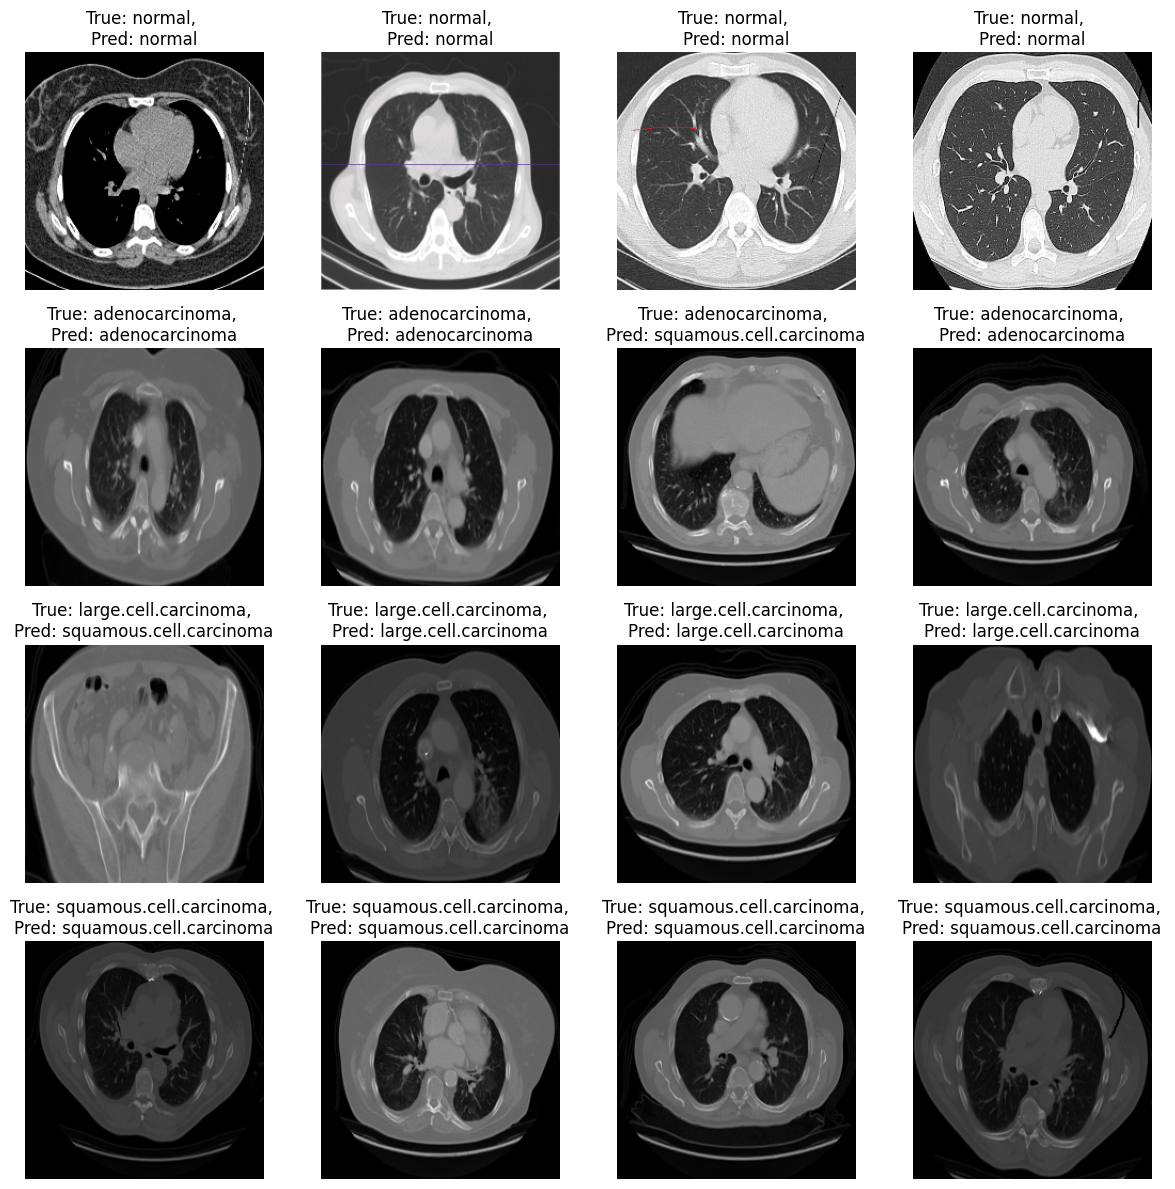

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
from PIL import Image

labels = np.arange(4)
fig, axes = plt.subplots(len(labels), 4, figsize=(12, len(labels) * 3))

if len(labels) == 1:
    axes = np.expand_dims(axes, axis=0)

for i, label in enumerate(labels):
    indices = np.where(test_dataset.labels == label)[0]
    num_to_sample = min(len(indices), 4)
    random_indices = np.random.choice(indices, size=num_to_sample, replace=False)

    for j in range(4):
        ax = axes[i, j]
        if j < num_to_sample:
            img = test_dataset.images[random_indices[j]]
            true_label = label

            input_img = img
            if isinstance(input_img, np.ndarray):
                input_img = torch.tensor(input_img)
            if isinstance(input_img, Image.Image):
                input_img = transforms.ToTensor()(input_img)
            if input_img.ndim == 3 and input_img.shape[0] in [1, 3]:
                input_img = input_img.unsqueeze(0)
            input_img = input_img.to(device)

            with torch.no_grad():
                outputs = model(input_img)
                probs = torch.softmax(outputs, dim=1)
                pred_label = torch.argmax(probs, dim=1).item()

            if isinstance(img, torch.Tensor):
                img = img.numpy()
                if img.ndim == 3 and img.shape[0] in [1, 3]:
                    img = np.transpose(img, (1, 2, 0))
            elif isinstance(img, Image.Image):
                img = np.array(img)

            if isinstance(img, np.ndarray):
                if img.ndim == 3 and img.shape[2] == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img)
            else:
                print(f"Unexpected image type: {type(img)}")

            ax.set_title(f"True: {idx2label[true_label]}, \nPred: {idx2label[pred_label]}")
        else:
            ax.axis("off")
        ax.axis("off")

plt.tight_layout()
plt.show()